# Installing & Importing the Libraries

In [1748]:
!pip install pymc
!pip install pymc_marketing

In [1749]:
!pip install --upgrade pymc3 arviz

  Using cached pymc3-3.11.6-py3-none-any.whl (872 kB)
  Using cached deprecat-2.1.1-py2.py3-none-any.whl (9.8 kB)
  Using cached numpy-1.22.1.zip (11.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
  Using cached pymc3-3.11.5-py3-none-any.whl (872 kB)


In [1750]:
!pip install pymc arviz --upgrade

In [1751]:
pip install pytimetk

Note: you may need to restart the kernel to use updated packages.


In [2675]:
import numpy as np
import pandas as pd
import pymc as pm
import pytimetk as tk
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from dateutil.parser import parse

# 1. Data collection

Load data set with a defeault route for users

In [2679]:
# Put your path location in file_path and run it
file_path = r'~/Downloads/task/MMM_test_data.csv'

def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['start_of_week'])
    return df

df = load_data(file_path)
df

start_of_week    revenue  spend_channel_1  spend_channel_2  \
0      2020-08-30  157906.75          2625.48           262.71   
1      2020-06-09  186425.68          2634.01           108.66   
2      2020-09-13  161607.39          2087.08           110.32   
3      2020-09-20  180089.13          1690.70            52.79   
4      2020-09-27  217793.98          1547.30            80.56   
..            ...        ...              ...              ...   
99     2022-07-24   72021.50             0.00          1118.78   
100    2022-07-31   90786.21             0.00           122.16   
101    2022-07-08  105929.40             0.00           754.09   
102    2022-08-14   90506.31             0.00          1043.22   
103    2022-08-21   84394.50             0.00           387.94   

     spend_channel_3  spend_channel_4  spend_channel_5  spend_channel_6  \
0           12954.12          3609.63         12955.29         12659.12   
1            8760.28          4560.60         12747.70         12338.18   
2            7155.42          4362.96         15015.41         10811.15   
3           15185.22          3883.41         15521.41         12890.22   
4           18524.05          4043.09         15793.74         12642.55   
..               ...              ...              ...              ...   
99          22305.10          4566.01          2987.70             0.00   
100         15812.65          4795.51          3293.40             0.00   
101         12166.85          4961.12          4057.03             0.00   
102         10856.58          4431.13          3086.81             0.00   
103         10757.63          4693.41          2972.11             0.00   

     spend_channel_7  
0           19379.79  
1           22473.45  
2           22596.05  
3           24728.73  
4           26515.48  
..               ...  
99          19916.88  
100         22687.98  
101         30142.64  
102         28622.78  
103         30547.18  

[104 rows x 9 columns]

In [2681]:
df.isnull().sum()

start_of_week      0
revenue            0
spend_channel_1    0
spend_channel_2    0
spend_channel_3    0
spend_channel_4    0
spend_channel_5    0
spend_channel_6    0
spend_channel_7    0
dtype: int64

In [2683]:
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 104 rows of 9 columns
start_of_week:    datetime64[ns]    [Timestamp('2020-08-30 00:00:00'), T ...
revenue:          float64           [157906.75, 186425.68, 161607.39, 18 ...
spend_channel_1:  float64           [2625.48, 2634.01, 2087.08, 1690.7,  ...
spend_channel_2:  float64           [262.71, 108.66, 110.32, 52.79, 80.5 ...
spend_channel_3:  float64           [12954.12, 8760.28, 7155.42, 15185.2 ...
spend_channel_4:  float64           [3609.63, 4560.6, 4362.96, 3883.41,  ...
spend_channel_5:  float64           [12955.29, 12747.7, 15015.41, 15521. ...
spend_channel_6:  float64           [12659.12, 12338.18, 10811.15, 12890 ...
spend_channel_7:  float64           [19379.79, 22473.45, 22596.05, 24728 ...


In [2685]:
df.describe()

revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
count     104.000000       104.000000       104.000000       104.000000   
mean   136490.190673      1245.604808       343.640962     19507.177981   
std     50810.253012      1388.384632       332.988218      8714.759886   
min     63207.090000         0.000000         4.370000      5938.130000   
25%    101675.685000       334.275000       120.470000     13879.000000   
50%    128790.460000       856.870000       202.020000     17929.450000   
75%    157707.280000      1658.032500       553.075000     22252.262500   
max    418186.380000      8513.830000      1605.850000     49689.380000   

       spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
count       104.000000       104.000000       104.000000       104.000000  
mean       6915.136731      8575.611442      5063.699038     27701.367404  
std        3123.172035      6956.787524      6689.472660     12176.293684  
min        3602.200000       747.460000         0.000000      9391.210000  
25%        5113.937500      2902.032500         0.000000     19797.710000  
50%        6194.400000      6879.270000      2423.095000     24248.640000  
75%        7470.557500     14367.582500      8701.960000     33852.652500  
max       22629.690000     33009.650000     33692.830000     77488.420000

 # 2. Data Exploration

In [2688]:
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 104 rows of 9 columns
start_of_week:    datetime64[ns]    [Timestamp('2020-08-30 00:00:00'), T ...
revenue:          float64           [157906.75, 186425.68, 161607.39, 18 ...
spend_channel_1:  float64           [2625.48, 2634.01, 2087.08, 1690.7,  ...
spend_channel_2:  float64           [262.71, 108.66, 110.32, 52.79, 80.5 ...
spend_channel_3:  float64           [12954.12, 8760.28, 7155.42, 15185.2 ...
spend_channel_4:  float64           [3609.63, 4560.6, 4362.96, 3883.41,  ...
spend_channel_5:  float64           [12955.29, 12747.7, 15015.41, 15521. ...
spend_channel_6:  float64           [12659.12, 12338.18, 10811.15, 12890 ...
spend_channel_7:  float64           [19379.79, 22473.45, 22596.05, 24728 ...


In [2690]:
df_copy = df.copy()
df_copy.head()

start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-06-09  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.70            52.79         15185.22   
4    2020-09-27  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
0          3609.63         12955.29         12659.12         19379.79  
1          4560.60         12747.70         12338.18         22473.45  
2          4362.96         15015.41         10811.15         22596.05  
3          3883.41         15521.41         12890.22         24728.73  
4          4043.09         15793.74         12642.55         26515.48

# 2.1 data visualization

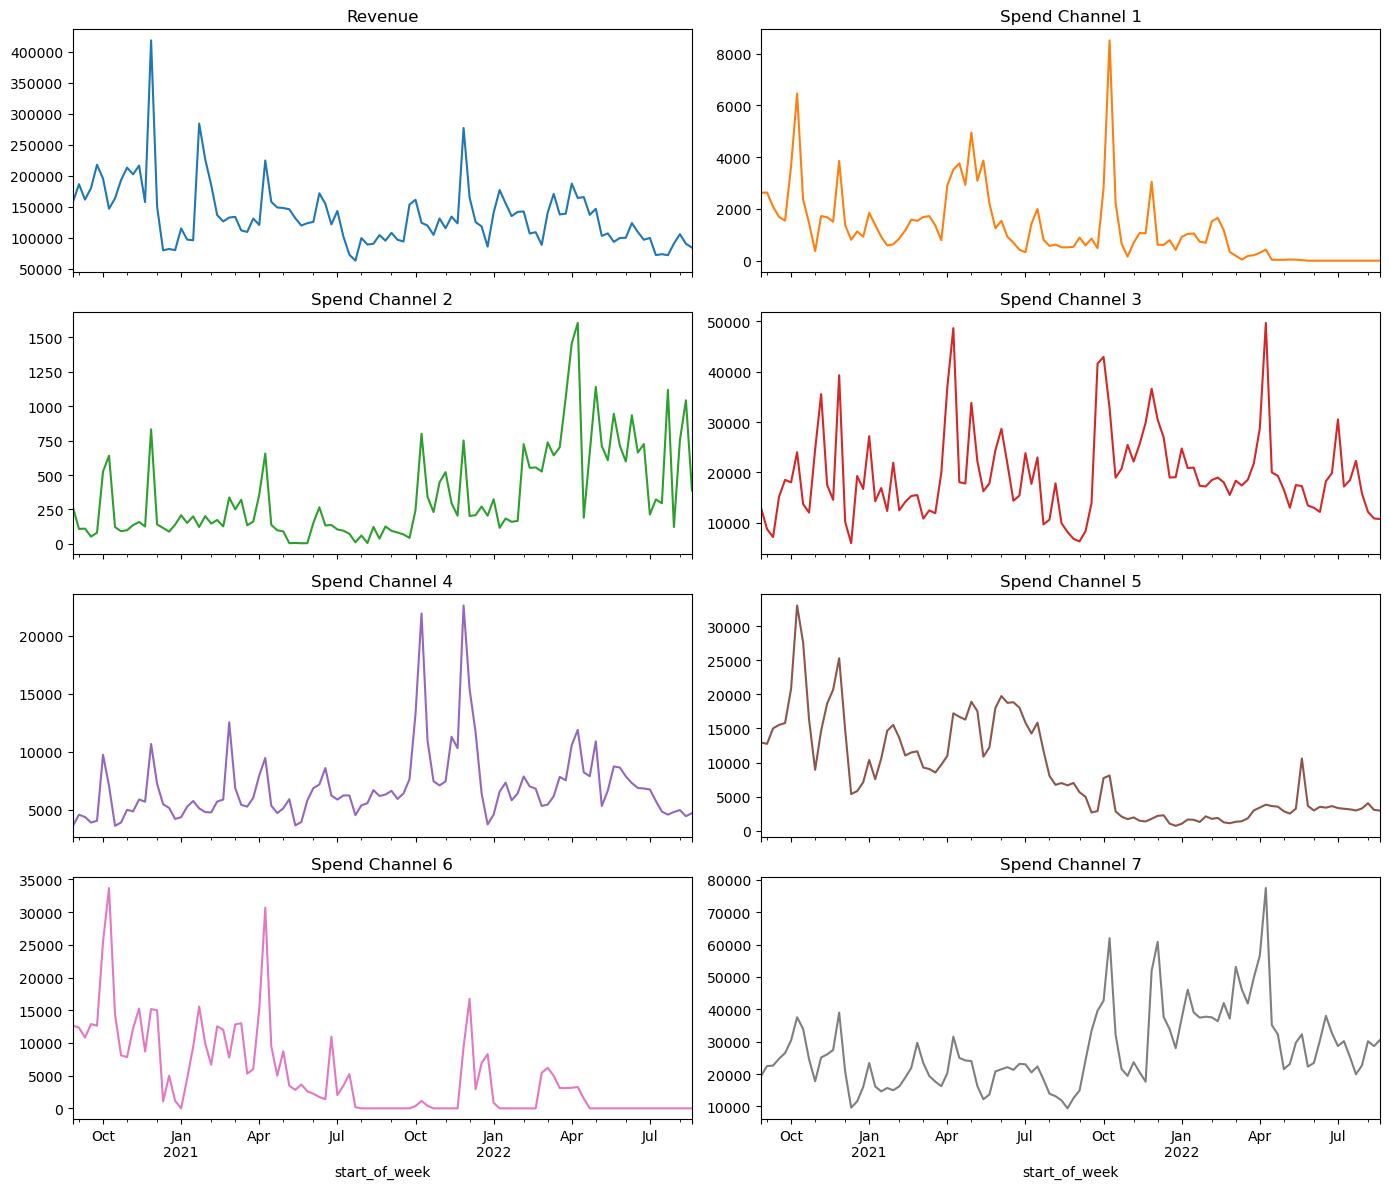

In [2693]:
df_copy_melt = df_copy.melt(id_vars=["start_of_week"], 
                         value_vars=["revenue", "spend_channel_1", "spend_channel_2", "spend_channel_3",
                                     "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"])

plot = melted_df.pivot(index='start_of_week', columns='variable', values='value').plot(subplots=True, layout=(4, 2)
                                                                                       , figsize=(14, 12), legend=False)

channels = ["Revenue", "Spend Channel 1", "Spend Channel 2", "Spend Channel 3", 
            "Spend Channel 4", "Spend Channel 5", "Spend Channel 6", "Spend Channel 7"]

for ax, title in zip(plot.flatten(), channels):
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [2694]:
total_revenue = df['revenue'].sum()
total_revenue

14194979.830000002

# 3. Data Cleaning

In [2698]:
# define year, month , day of year from the start_of_week column
df_features = df.assign(year = lambda x: x["start_of_week"].dt.year,
                        month = lambda x: x["start_of_week"].dt.month,
                        dayofyear = lambda x: x["start_of_week"].dt.dayofyear).assign(
    trend = lambda x: df.index)
df_features.head()

start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-06-09  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.70            52.79         15185.22   
4    2020-09-27  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  year  \
0          3609.63         12955.29         12659.12         19379.79  2020   
1          4560.60         12747.70         12338.18         22473.45  2020   
2          4362.96         15015.41         10811.15         22596.05  2020   
3          3883.41         15521.41         12890.22         24728.73  2020   
4          4043.09         15793.74         12642.55         26515.48  2020   

   month  dayofyear  trend  
0      8        243      0  
1      6        161      1  
2      9        257      2  
3      9        264      3  
4      9        271      4

In [2700]:
df_features.glimpse()

<class 'pandas.core.frame.DataFrame'>: 104 rows of 13 columns
start_of_week:    datetime64[ns]    [Timestamp('2020-08-30 00:00:00'), T ...
revenue:          float64           [157906.75, 186425.68, 161607.39, 18 ...
spend_channel_1:  float64           [2625.48, 2634.01, 2087.08, 1690.7,  ...
spend_channel_2:  float64           [262.71, 108.66, 110.32, 52.79, 80.5 ...
spend_channel_3:  float64           [12954.12, 8760.28, 7155.42, 15185.2 ...
spend_channel_4:  float64           [3609.63, 4560.6, 4362.96, 3883.41,  ...
spend_channel_5:  float64           [12955.29, 12747.7, 15015.41, 15521. ...
spend_channel_6:  float64           [12659.12, 12338.18, 10811.15, 12890 ...
spend_channel_7:  float64           [19379.79, 22473.45, 22596.05, 24728 ...
year:             int64             [2020, 2020, 2020, 2020, 2020, 2020, ...
month:            int64             [8, 6, 9, 9, 9, 4, 11, 10, 10, 1, 8, ...
dayofyear:        int64             [243, 161, 257, 264, 271, 101, 315,  ...
trend:        

# 4. Preprocessiing

Identify features (X) and target (y)

X = df_features[['start_of_week', 'spend_channel_1', 'spend_channel_2', 'spend_channel_3', 
        'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 
        'spend_channel_7', 'year', 'month', 'dayofyear', 'trend']]
y = df_features['revenue']

In [2912]:
x = df_features.drop("revenue", axis=1)
y = df_features["revenue"]

Creat dummies

In [2916]:
dummy_model = DelayedSaturatedMMM(
    date_column = "start_of_week", channel_columns = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                                                       'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 
                                                       'spend_channel_7'], 
    control_columns = ["year", "month",	"dayofyear", "trend"], adstock_max_lag=8)

# 5. Modeling (bayesian mixed-media model logistic)

Update the Model with Test Data

Posterior Predictive Checks

Plot Observed vs. Predicted Revenue

Calculate Error Metrics

Plot Residuals

In [2924]:
total_spend_per_channel = df_copy[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                                   'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 'spend_channel_7']].sum(axis=0)
total_spend_per_channel

spend_channel_1     129542.90
spend_channel_2      35738.66
spend_channel_3    2028746.51
spend_channel_4     719174.22
spend_channel_5     891863.59
spend_channel_6     526624.70
spend_channel_7    2880942.21
dtype: float64

In [2926]:
spend_porportion = total_spend_per_channel / total_spend_per_channel.sum()
spend_porportion

spend_channel_1    0.017961
spend_channel_2    0.004955
spend_channel_3    0.281277
spend_channel_4    0.099710
spend_channel_5    0.123653
spend_channel_6    0.073014
spend_channel_7    0.399430
dtype: float64

In [2928]:
n_channels = 5

In [2930]:
halfnormal_scale = 1 / np.sqrt(1 - 2 /np.pi)
halfnormal_scale

1.658896739970306

In [2932]:
prior_sigma = halfnormal_scale * n_channels * spend_porportion
prior_sigma.tolist()

[0.148973544580175,
 0.04109924093675312,
 2.333046107886727,
 0.8270459648817694,
 1.0256376866991546,
 0.6056151917432085,
 3.313065963123744]

In [2934]:
dummy_model.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'intercept_tvp_kwargs': {'m': 200,
  'L': None,
  'eta_lam': 1,
  'ls_mu': None,
  'ls_sigma': 10,
  'cov_func': None}}

In [2936]:
#Customization the model for later changes
model_config = {'intercept': {'dist': 'Normal', 
                              'kwargs': {'mu': 0, 'sigma': 2}
                             },
 'beta_channel': {'dist': 'HalfNormal', 
                  'kwargs': {'sigma': 2}
                 },
 'alpha': {'dist': 'Beta', 
           'kwargs': {'alpha': 1, 'beta': 3}
          },
 'lam': {'dist': 'Gamma', 
         'kwargs': {'alpha': 3, 'beta': 1}
        },
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 
                       'kwargs': {'sigma': 2}}}
               },
 'gamma_control': {'dist': 'Normal', 
                   'kwargs': {'mu': 0, 'sigma': 2}
                  },
 'gamma_fourier': {'dist': 'Laplace', 
                   'kwargs': {'mu': 0, 'b': 1}
                  },
 'intercept_tvp_kwargs': {'m': 200,
  'L': None,
  'eta_lam': 1,
  'ls_mu': None,
  'ls_sigma': 10,
  'cov_func': None}}


In [2938]:
#deployed the model 
mmm = DelayedSaturatedMMM(
    model_config=model_config,
    date_column="start_of_week",
    channel_columns=['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 
                     'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 
                     'spend_channel_7'],
    control_columns=["year", "month", "dayofyear", "trend"],
    adstock_max_lag=8,
    yearly_seasonality=2
)
mmm.model_config
mmm.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'intercept_tvp_kwargs': {'m': 200,
  'L': None,
  'eta_lam': 1,
  'ls_mu': None,
  'ls_sigma': 10,
  'cov_func': None}}

Model fitting

In [2941]:
df_features.head()

start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-06-09  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.70            52.79         15185.22   
4    2020-09-27  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  year  \
0          3609.63         12955.29         12659.12         19379.79  2020   
1          4560.60         12747.70         12338.18         22473.45  2020   
2          4362.96         15015.41         10811.15         22596.05  2020   
3          3883.41         15521.41         12890.22         24728.73  2020   
4          4043.09         15793.74         12642.55         26515.48  2020   

   month  dayofyear  trend  
0      8        243      0  
1      6        161      1  
2      9        257      2  
3      9        264      3  
4      9        271      4

In [2943]:
df_features

start_of_week    revenue  spend_channel_1  spend_channel_2  \
0      2020-08-30  157906.75          2625.48           262.71   
1      2020-06-09  186425.68          2634.01           108.66   
2      2020-09-13  161607.39          2087.08           110.32   
3      2020-09-20  180089.13          1690.70            52.79   
4      2020-09-27  217793.98          1547.30            80.56   
..            ...        ...              ...              ...   
99     2022-07-24   72021.50             0.00          1118.78   
100    2022-07-31   90786.21             0.00           122.16   
101    2022-07-08  105929.40             0.00           754.09   
102    2022-08-14   90506.31             0.00          1043.22   
103    2022-08-21   84394.50             0.00           387.94   

     spend_channel_3  spend_channel_4  spend_channel_5  spend_channel_6  \
0           12954.12          3609.63         12955.29         12659.12   
1            8760.28          4560.60         12747.70         12338.18   
2            7155.42          4362.96         15015.41         10811.15   
3           15185.22          3883.41         15521.41         12890.22   
4           18524.05          4043.09         15793.74         12642.55   
..               ...              ...              ...              ...   
99          22305.10          4566.01          2987.70             0.00   
100         15812.65          4795.51          3293.40             0.00   
101         12166.85          4961.12          4057.03             0.00   
102         10856.58          4431.13          3086.81             0.00   
103         10757.63          4693.41          2972.11             0.00   

     spend_channel_7  year  month  dayofyear  trend  
0           19379.79  2020      8        243      0  
1           22473.45  2020      6        161      1  
2           22596.05  2020      9        257      2  
3           24728.73  2020      9        264      3  
4           26515.48  2020      9        271      4  
..               ...   ...    ...        ...    ...  
99          19916.88  2022      7        205     99  
100         22687.98  2022      7        212    100  
101         30142.64  2022      7        189    101  
102         28622.78  2022      8        226    102  
103         30547.18  2022      8        233    103  

[104 rows x 13 columns]

In [2965]:
trace = mmm.fit(x, y, target_accept = 0.95, random_seed = 888)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, gamma_fourier, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 214 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


model summary

In [2972]:
summary = az.summary(trace)
print(summary)

                                    mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]             0.261  0.202   0.000    0.637      0.004   
alpha[spend_channel_2]             0.250  0.192   0.000    0.602      0.003   
alpha[spend_channel_3]             0.179  0.147   0.000    0.448      0.002   
alpha[spend_channel_4]             0.196  0.174   0.000    0.531      0.003   
alpha[spend_channel_5]             0.224  0.173   0.000    0.536      0.003   
...                                  ...    ...     ...      ...        ...   
mu[2022-07-24T00:00:00.000000000]  0.248  0.035   0.181    0.314      0.001   
mu[2022-07-31T00:00:00.000000000]  0.201  0.032   0.142    0.265      0.001   
mu[2022-07-08T00:00:00.000000000]  0.205  0.027   0.153    0.255      0.000   
mu[2022-08-14T00:00:00.000000000]  0.205  0.032   0.145    0.261      0.001   
mu[2022-08-21T00:00:00.000000000]  0.189  0.030   0.134    0.248      0.000   

                                   mcse_sd  ess_bul

Heatmap

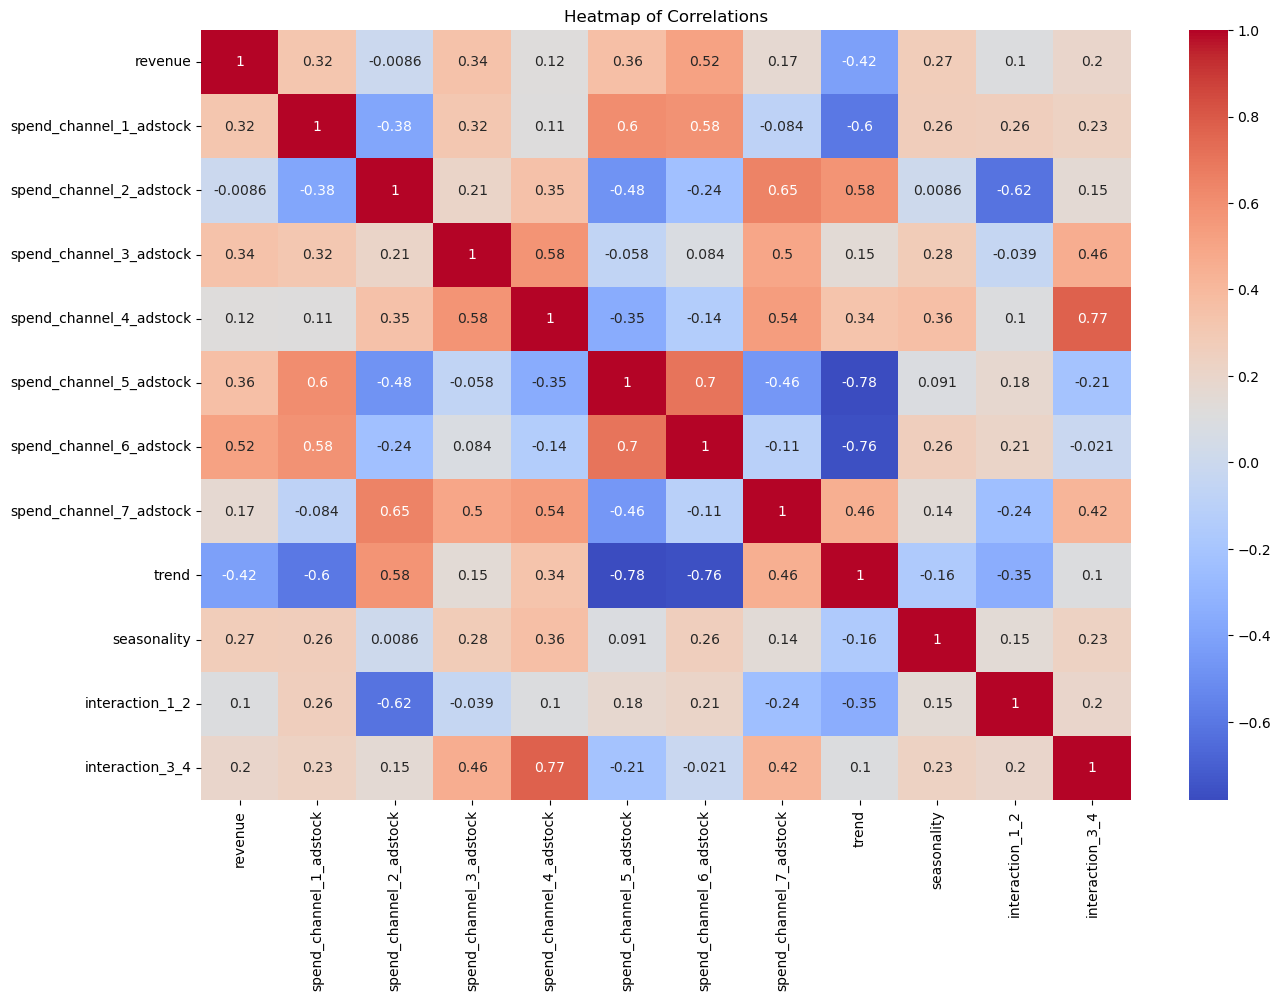

In [1095]:
plt.figure(figsize=(15, 10))
corr_matrix = df_proc[['revenue', 'spend_channel_1_adstock', 'spend_channel_2_adstock',
                       'spend_channel_3_adstock', 'spend_channel_4_adstock',
                       'spend_channel_5_adstock', 'spend_channel_6_adstock',
                       'spend_channel_7_adstock', 'trend', 'seasonality', 
                       'interaction_1_2', 'interaction_3_4']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlations')
plt.show();

Pairplot

<Figure size 2000x2000 with 0 Axes>

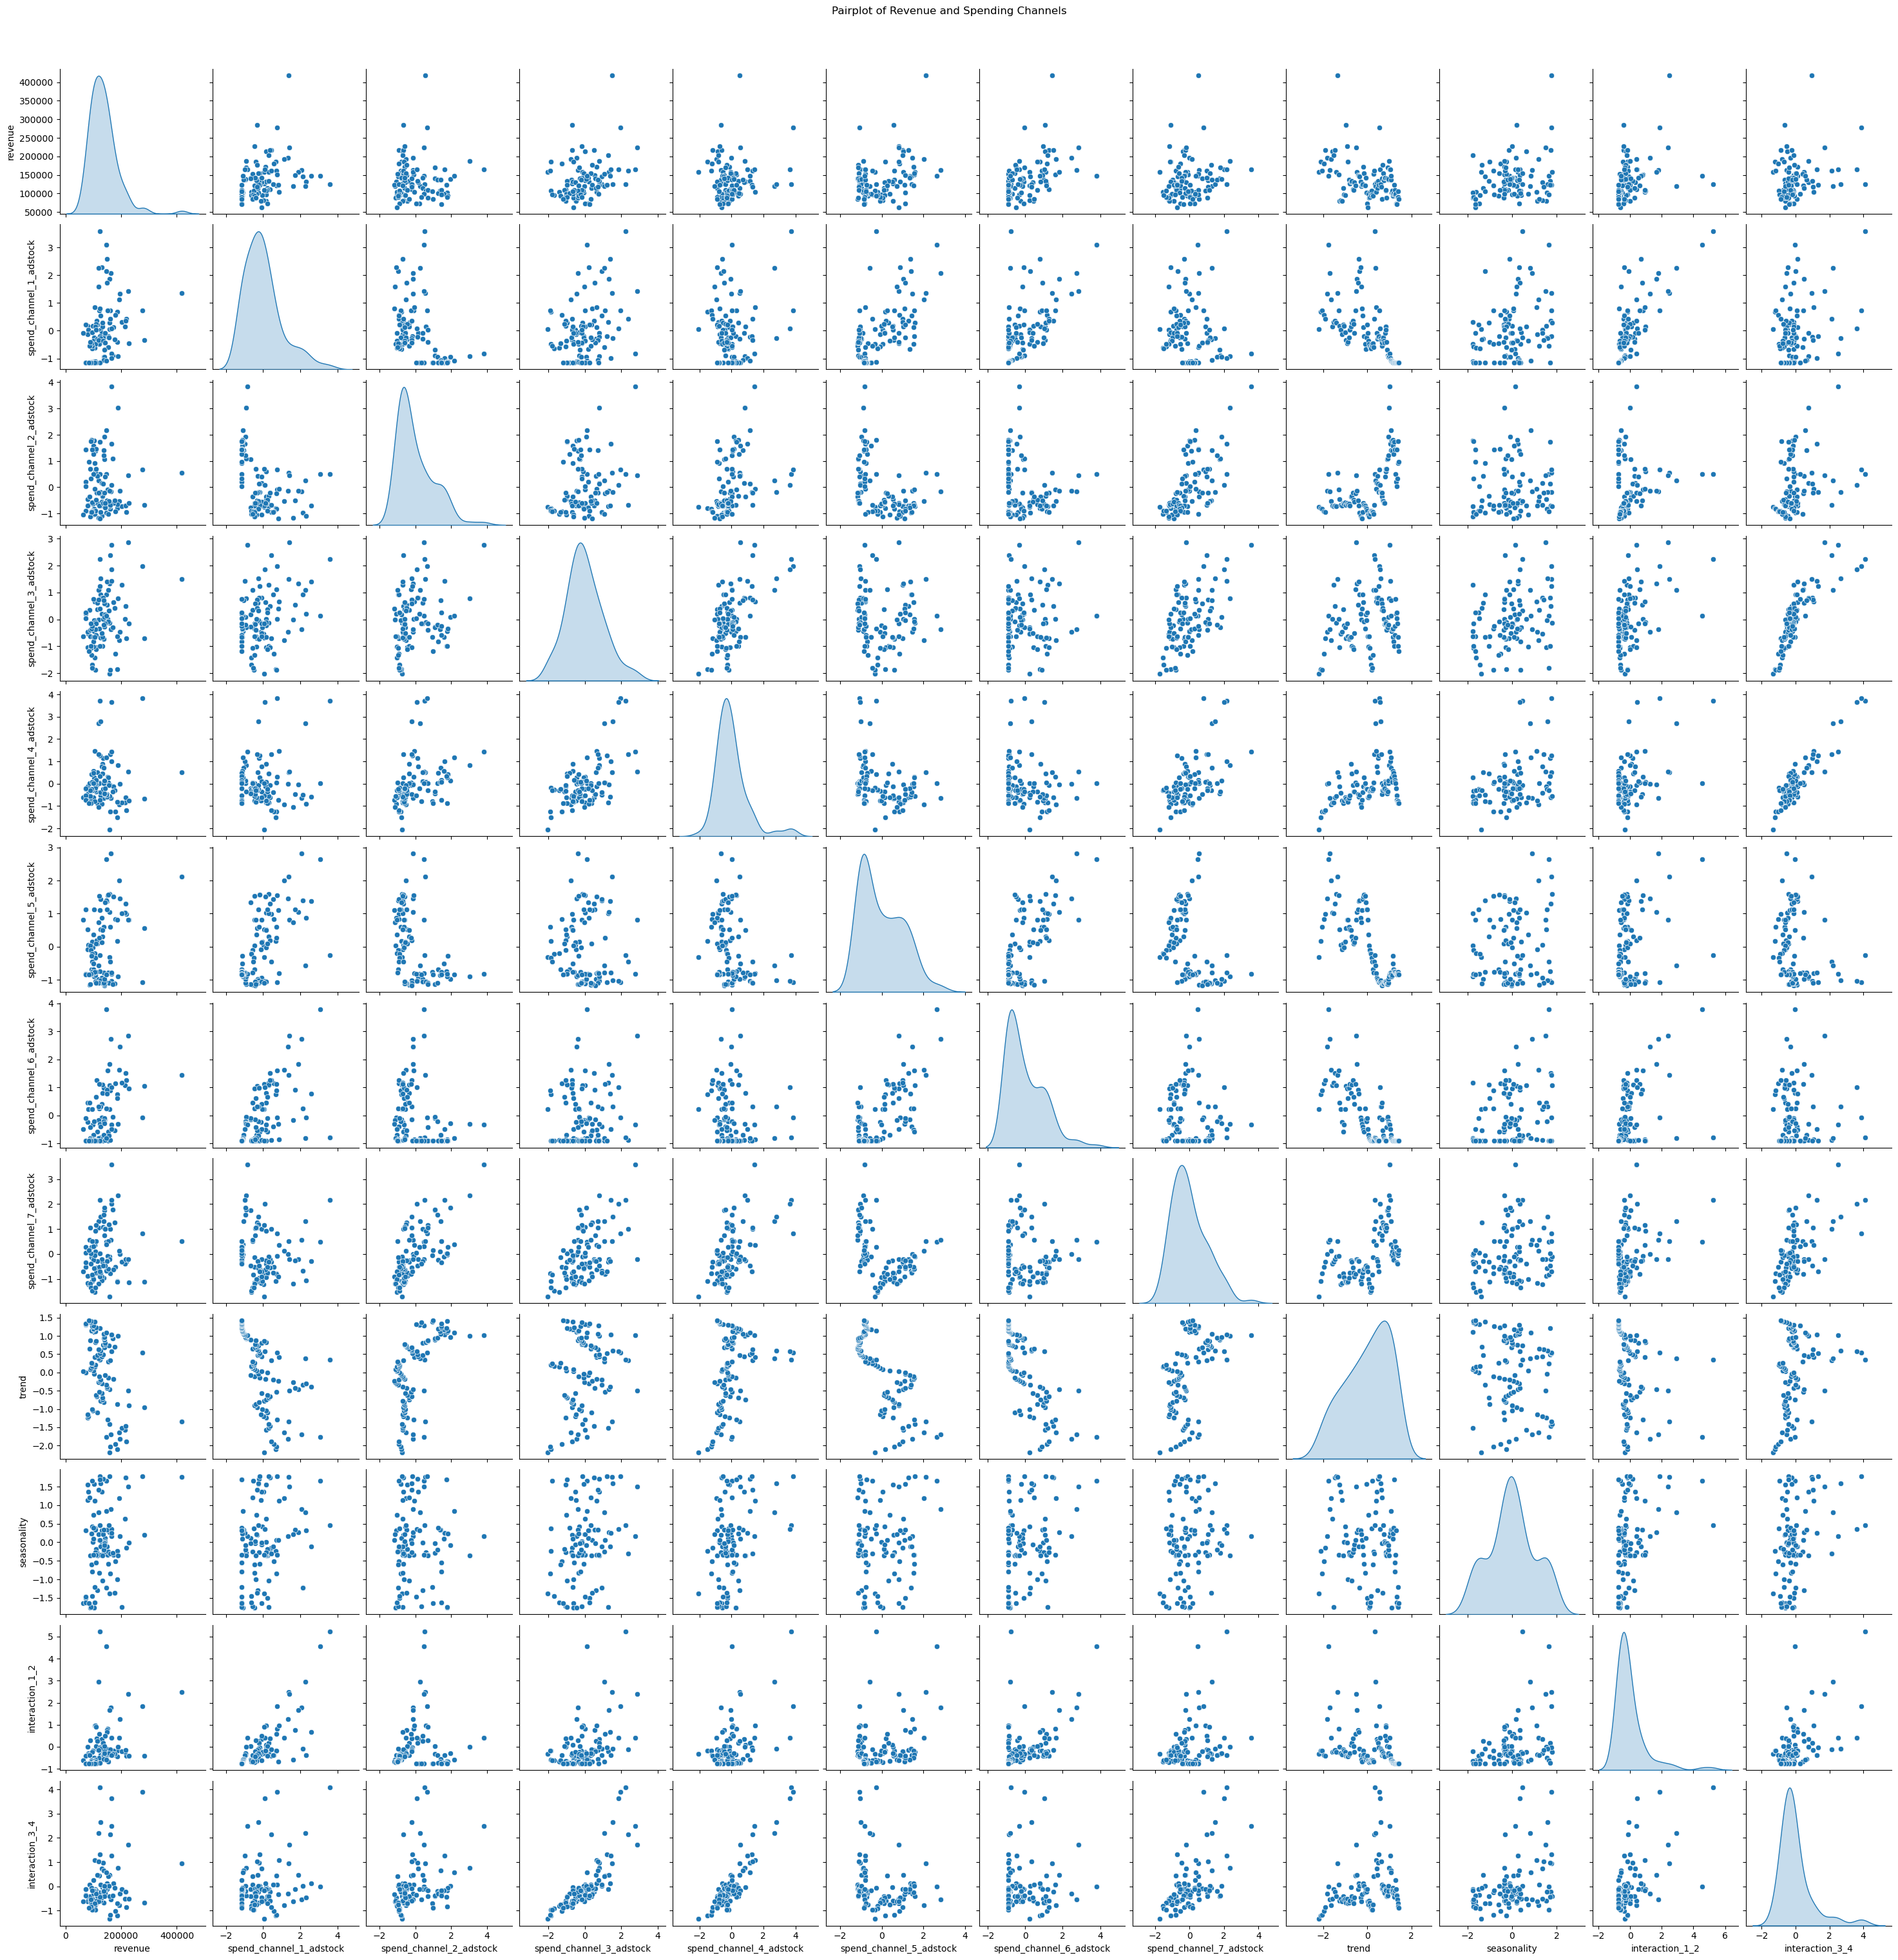

In [821]:
columns_to_plot = ['revenue', 'spend_channel_1_adstock', 'spend_channel_2_adstock', 
                   'spend_channel_3_adstock', 'spend_channel_4_adstock', 
                   'spend_channel_5_adstock', 'spend_channel_6_adstock', 
                   'spend_channel_7_adstock', 'trend', 'seasonality', 
                   'interaction_1_2', 'interaction_3_4']

plt.figure(figsize=(20, 20))
sns.pairplot(df_proc[columns_to_plot], diag_kind='kde', height=2.5)

plt.suptitle('Pairplot of Revenue and Spending Channels', y=1.02)
plt.show();

Box plot

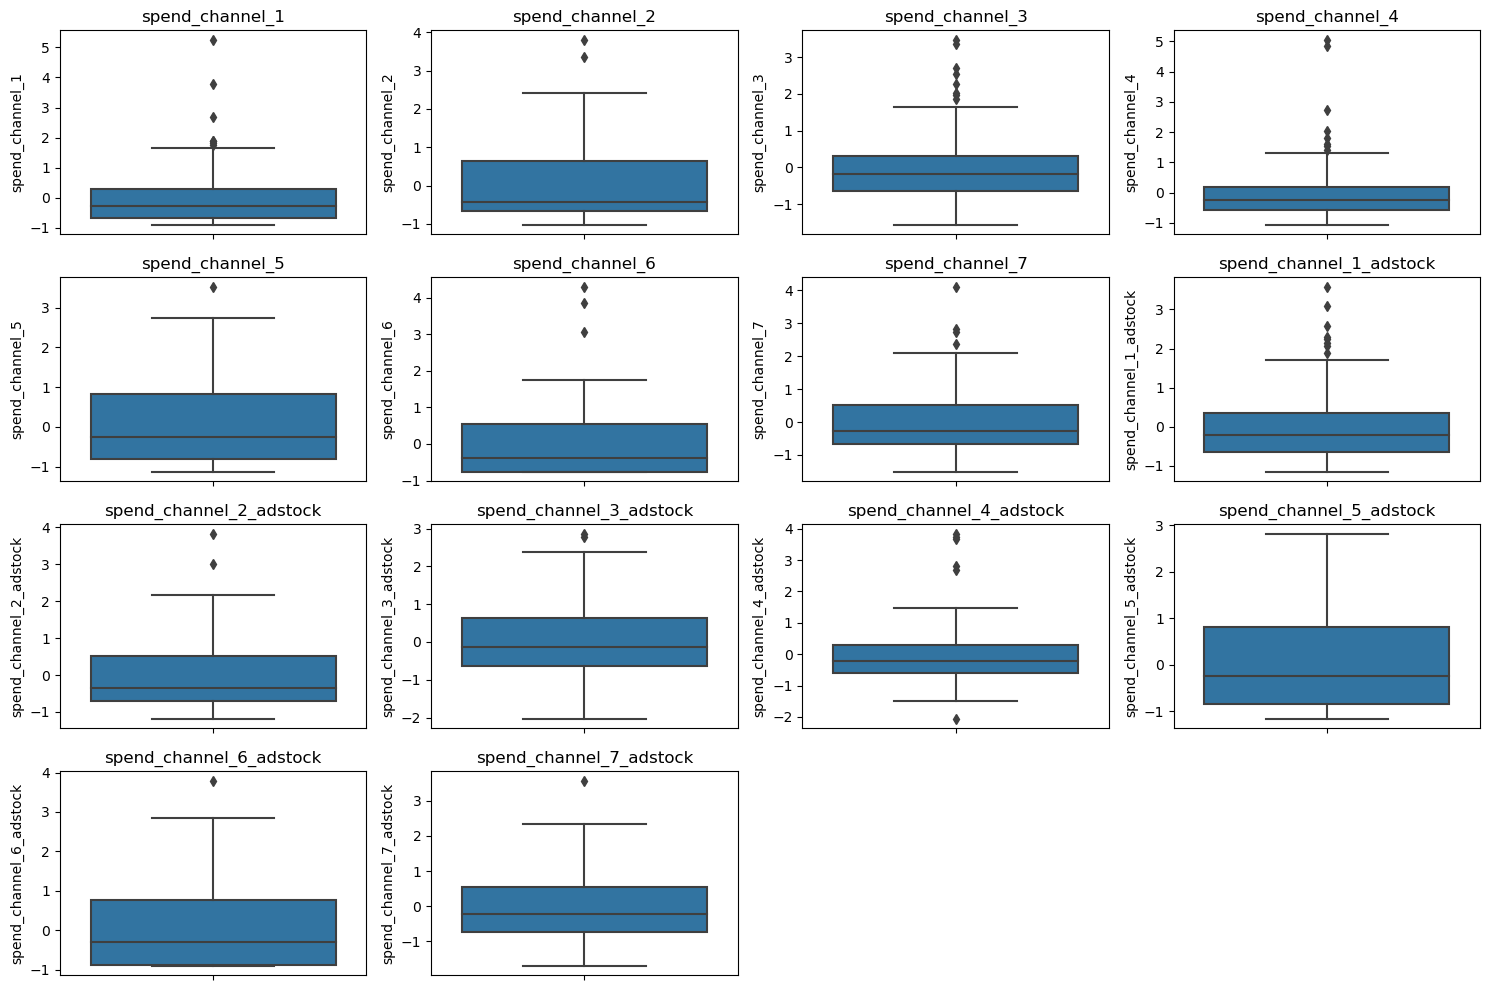

In [823]:
columns_to_plot = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 
                   'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 
                   'spend_channel_7', 'spend_channel_1_adstock', 
                   'spend_channel_2_adstock', 'spend_channel_3_adstock', 
                   'spend_channel_4_adstock', 'spend_channel_5_adstock', 
                   'spend_channel_6_adstock', 'spend_channel_7_adstock']

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df_proc[column])
    plt.title(column)
    plt.tight_layout()

plt.show();

Line plot

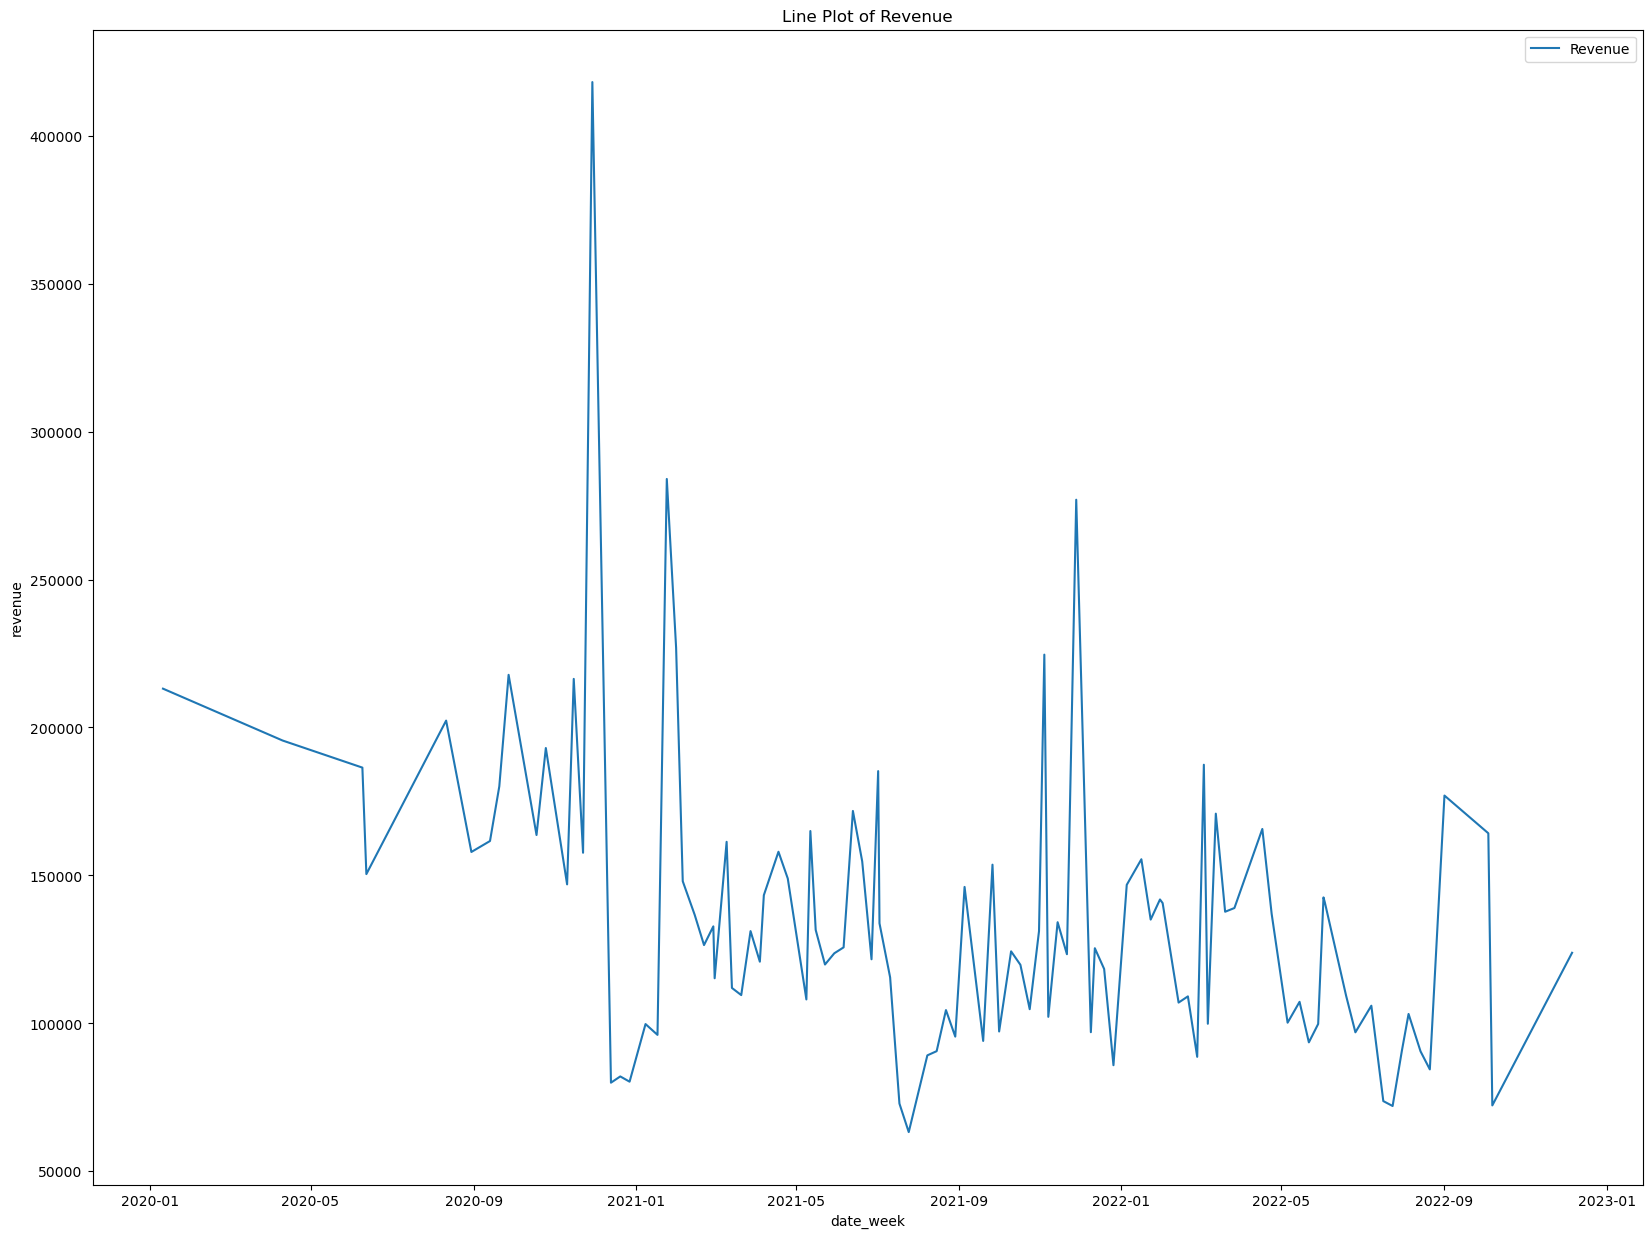

In [825]:
plt.figure(figsize=(20, 15))
sns.lineplot(x='date_week', y='revenue', data=df_proc, label='Revenue')
plt.legend()
plt.title('Line Plot of Revenue')
plt.show()

Plotting Trend and Seasonality

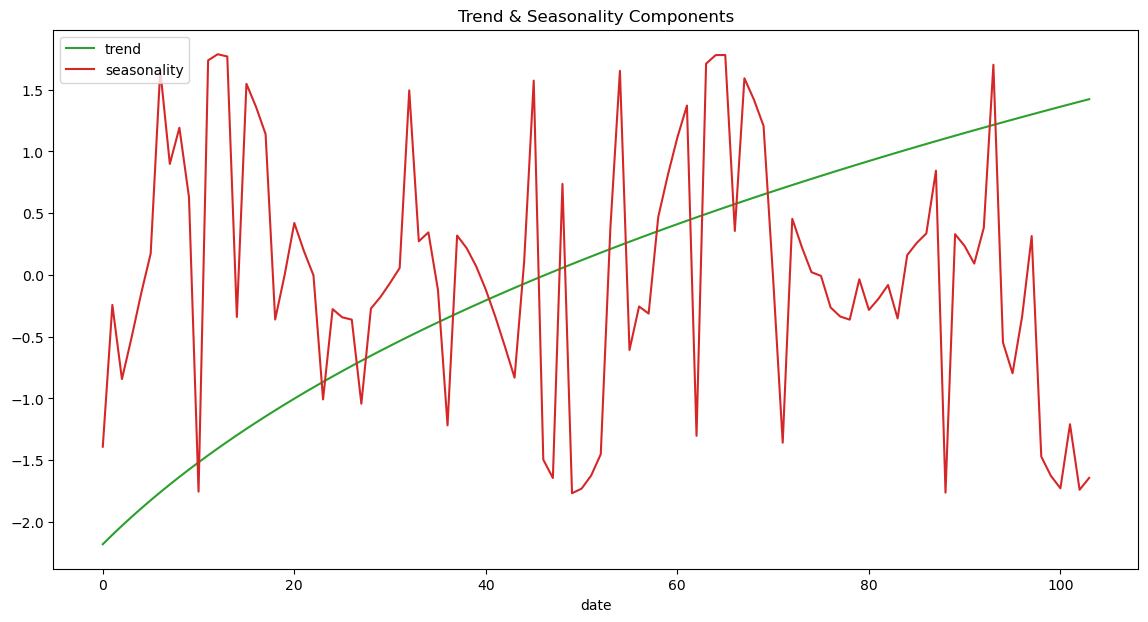

In [827]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x=df_proc.index, y=df_proc["trend"], color="C2", label="trend", ax=ax)
sns.lineplot(x=df_proc.index, y=df_proc["seasonality"], color="C3", label="seasonality", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None)
plt.show();

Bar plot

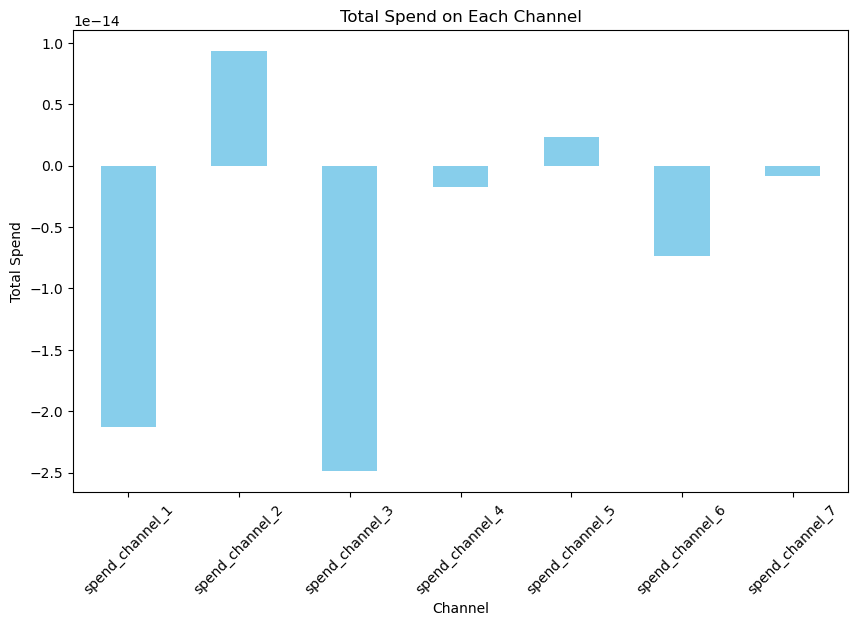

In [789]:
total_spend = df_proc[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                       'spend_channel_7']].sum()

# Plot total spend
plt.figure(figsize=(10, 6))
total_spend.plot(kind='bar', color='skyblue')
plt.title('Total Spend on Each Channel')
plt.xlabel('Channel')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.show()

Find the highest peak in lineplot

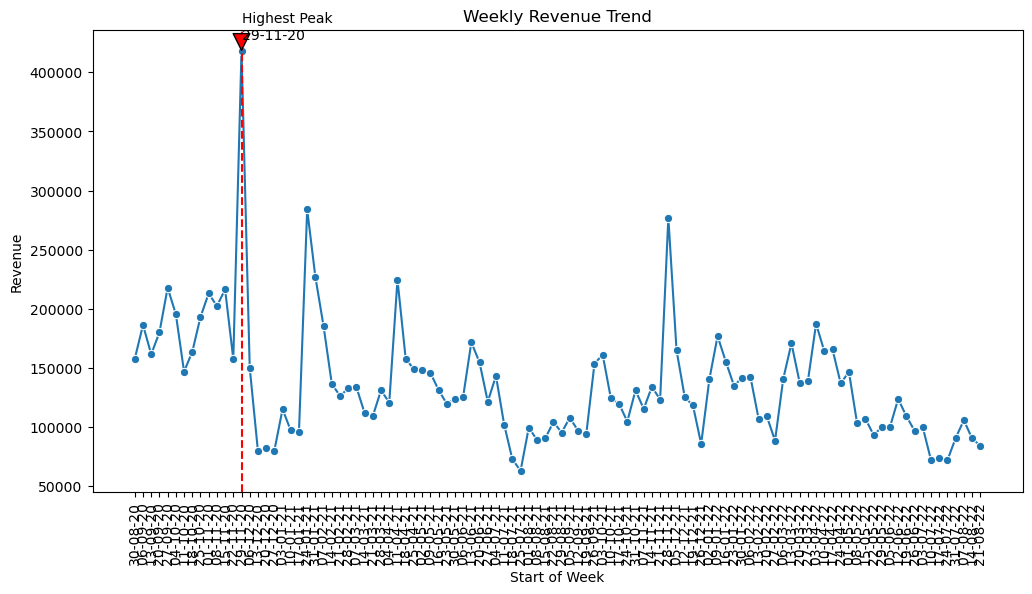

Date with the highest peak in revenue: 29-11-20


In [795]:
if 'level_0' in df_proc.columns:
    df_proc = df_proc.drop(columns=['level_0'])

df_proc.reset_index(inplace=True)

max_revenue = df_proc['revenue'].max()
max_revenue_date = df_proc[df_proc['revenue'] == max_revenue]['start_of_week'].iloc[0]

plt.figure(figsize=(12, 6))
sns.lineplot(x='start_of_week', y='revenue', data=df_proc, marker='o')

plt.axvline(x=max_revenue_date, color='red', linestyle='--')
plt.annotate(f'Highest Peak\n{max_revenue_date}',
             xy=(max_revenue_date, max_revenue),
             xytext=(max_revenue_date, max_revenue + 10000), 
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.xticks(rotation=90)
plt.title('Weekly Revenue Trend')
plt.xlabel('Start of Week')
plt.ylabel('Revenue')
plt.show()

print("Date with the highest peak in revenue:", max_revenue_date);

In [1227]:
print(df.columns)

Index(['start_of_week', 'revenue', 'spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7'],
      dtype='object')


In [1229]:
def adstock(spend, rate=0.5):
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    for t in range(1, len(spend)):
        adstocked_spend[t] = spend[t] + rate * adstocked_spend[t-1]
    return adstocked_spend

In [1211]:
# Apply adstock transformation to each channel for training data
adstocked_spends_train = {f'adstocked_spend_channel_{i}': adstock(X_train.iloc[:, i]) for i in range(X_train.shape[1])}

# Create a DataFrame with adstocked spends for training data
adstocked_data_train = pd.DataFrame(adstocked_spends_train)
adstocked_data_train['revenue'] = y_train.values

In [1213]:
# Apply adstock transformation to each channel for testing data
adstocked_spends_test = {f'adstocked_spend_channel_{i}': adstock(X_test.iloc[:, i].values) for i in range(X_test.shape[1])}

# Create a DataFrame with adstocked spends for testing data
adstocked_data_test = pd.DataFrame(adstocked_spends_test)
adstocked_data_test['revenue'] = y_test.values

? model

In [1217]:
import pymc as pm

# Get the adstocked spend column names
adstocked_spend_columns = list(adstocked_spends_train.keys())

# Define the model
with pm.Model() as model:
    # Priors for the regression coefficients
    coefs = pm.Normal('coefs', mu=0, sigma=1, shape=len(adstocked_spend_columns))
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Expected revenue
    mu = intercept + pm.math.dot(adstocked_data_train[adstocked_spend_columns].values, coefs)

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    revenue_obs = pm.Normal('revenue_obs', mu=mu, sigma=sigma, observed=adstocked_data_train['revenue'])

    # Inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


# Model analysis and visualization 

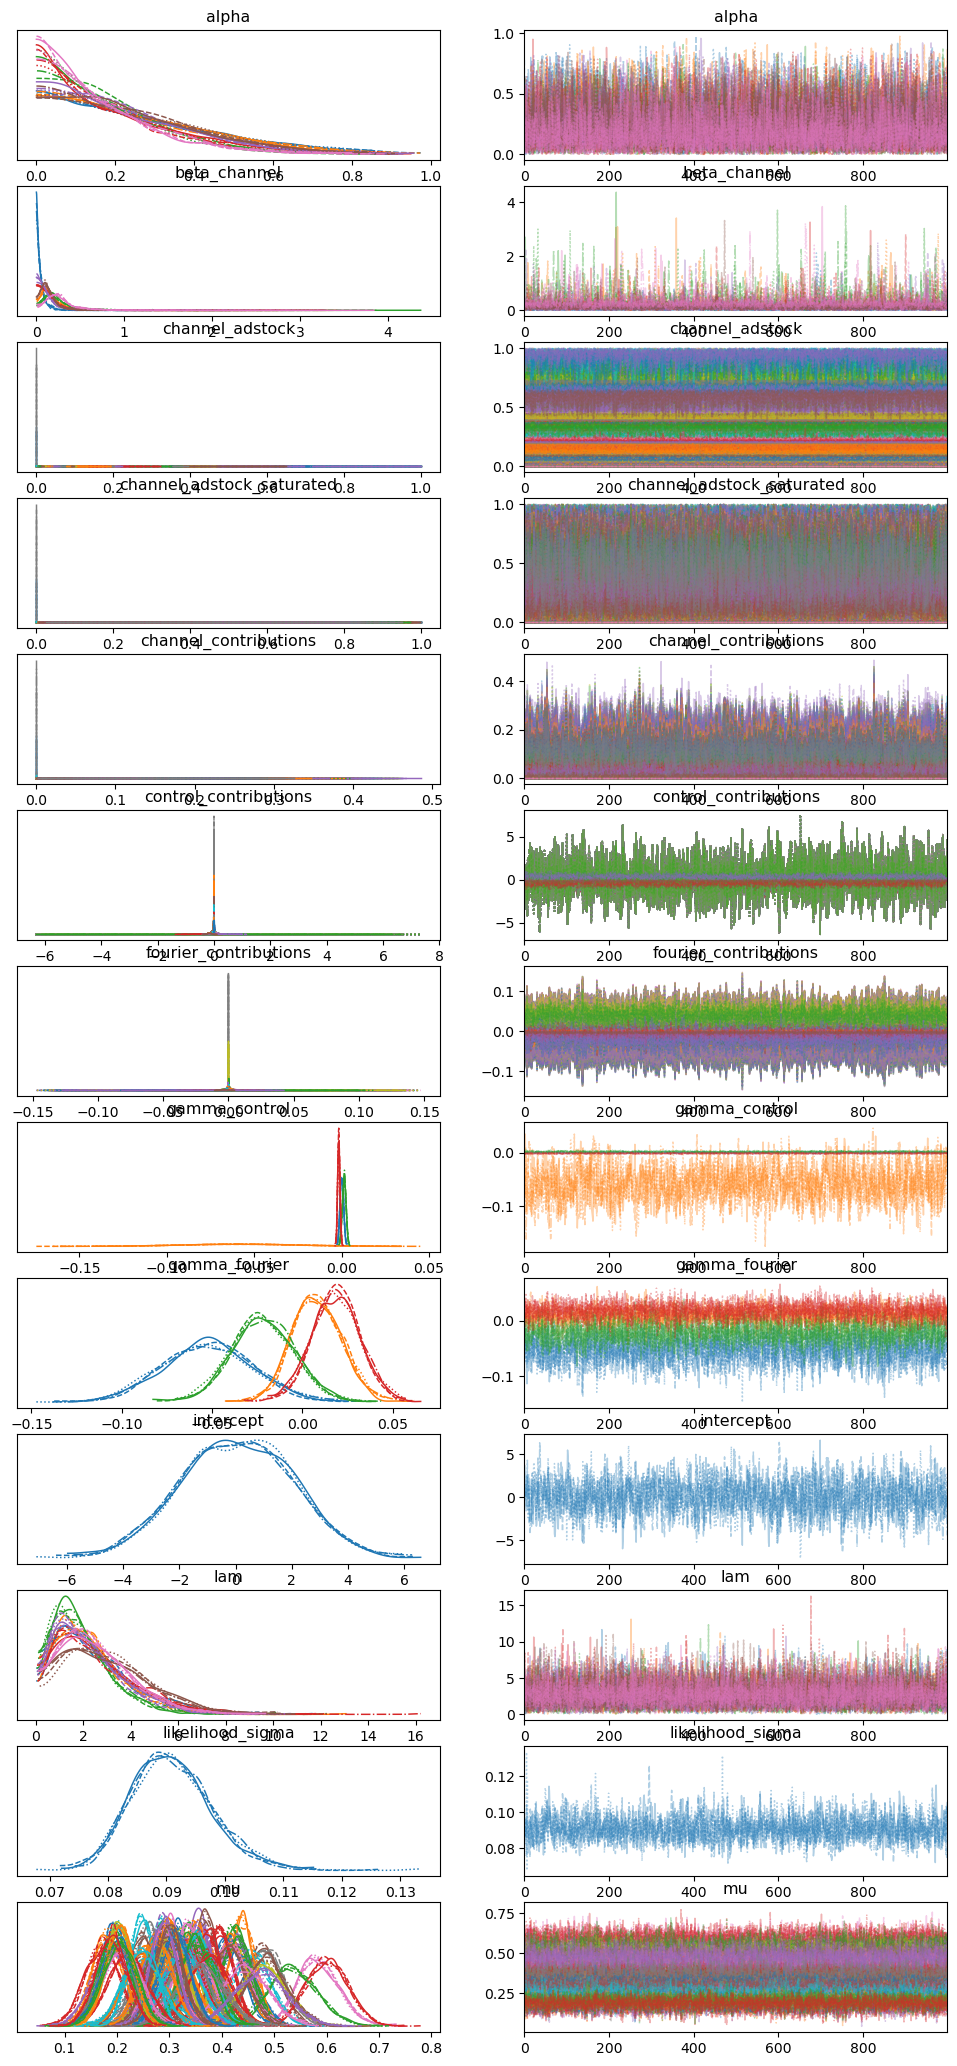

In [2983]:
# Plot trace
az.plot_trace(trace)
plt.show()

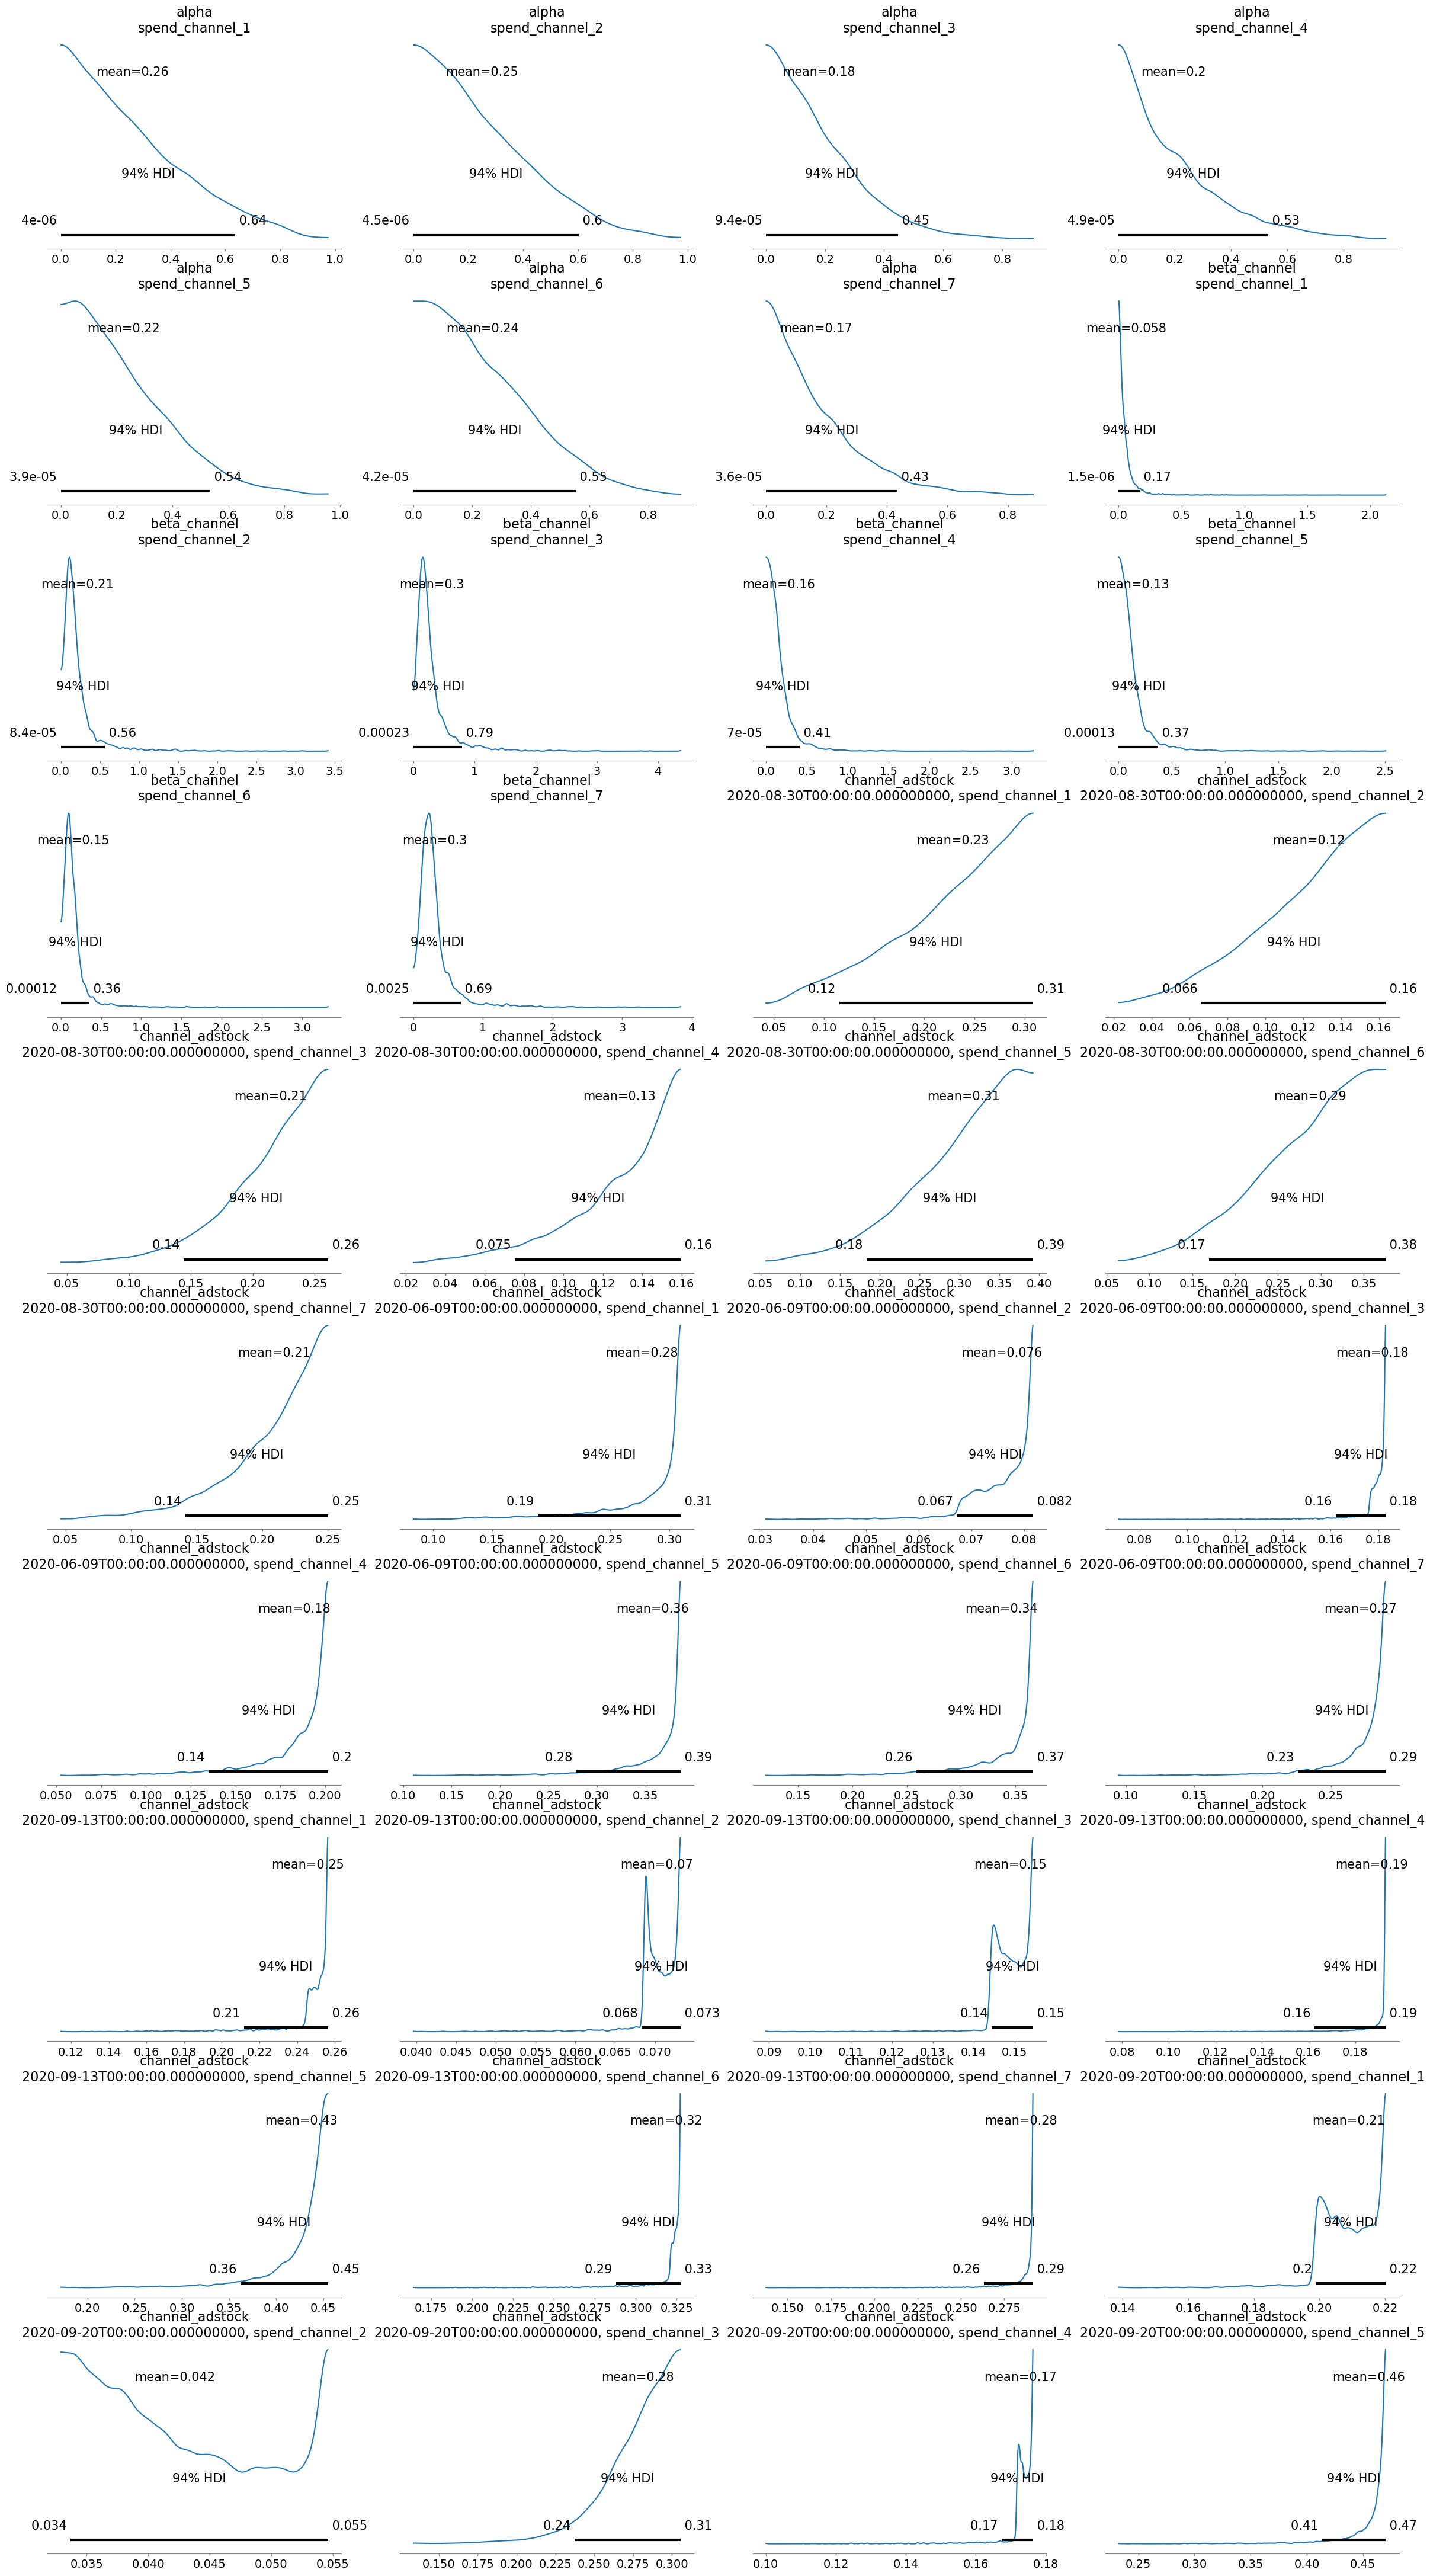

In [2984]:
# Plot posterior distributions
az.plot_posterior(trace)
plt.show()

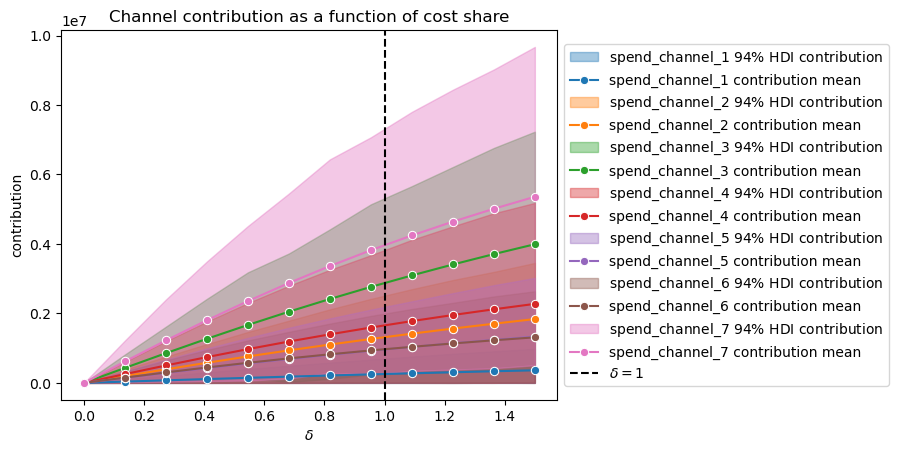

In [2998]:
fig = mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12)

# Model Performance and Validation

Validation and Interpretation

In [3006]:
predictions = dummy_model.predict(x)

mae = mean_absolute_error(y, predictions)

mse = mean_squared_error(y, predictions)

rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

AttributeError: 'DelayedSaturatedMMM' object has no attribute 'preprocessed_data'

Posterior Predictive Checks

Calculate Error Metrics

Plot Residuals

In [3008]:
# Reinitialize the model
dummy_model = DelayedSaturatedMMM(
    date_column="start_of_week", 
    channel_columns=['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                     'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 
                     'spend_channel_7'], 
    control_columns=["year", "month", "dayofyear", "trend"], 
    adstock_max_lag=8
)

# Refit the model
trace = dummy_model.fit(x, y, target_accept=0.95, random_seed=888)

# Make predictions
predictions = dummy_model.predict(x)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 199 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y]


Output()

In [3010]:
# Print data shapes to ensure consistency
print("x shape:", x.shape)
print("y shape:", y.shape)

# Ensure that the data used for prediction is consistent with the training data
predictions = dummy_model.predict(x)

Sampling: [y]


Output()

x shape: (104, 12)
y shape: (104,)


In [3012]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y, predictions)

# Calculate MSE
mse = mean_squared_error(y, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 26406.491707708283
Mean Squared Error (MSE): 1326761570.6816764
Root Mean Squared Error (RMSE): 36424.73844355888


In [3018]:
# Baseline model: predicting the mean revenue
mean_revenue = y.mean()
baseline_predictions = [mean_revenue] * len(y)

# Calculate baseline errors
baseline_mae = mean_absolute_error(y, baseline_predictions)
baseline_mse = mean_squared_error(y, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')
print(f'Baseline Mean Squared Error (MSE): {baseline_mse}')
print(f'Baseline Root Mean Squared Error (RMSE): {baseline_rmse}')

# Your model's predictions
predictions = dummy_model.predict(x)

# Calculate model errors
mae = mean_absolute_error(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f'Model Mean Absolute Error (MAE): {mae}')
print(f'Model Mean Squared Error (MSE): {mse}')
print(f'Model Root Mean Squared Error (RMSE): {rmse}')

# Compare model performance with baseline
print(f'Improvement over baseline MAE: {baseline_mae - mae}')
print(f'Improvement over baseline MSE: {baseline_mse - mse}')
print(f'Improvement over baseline RMSE: {baseline_rmse - rmse}')

Sampling: [y]


Output()

Baseline Mean Absolute Error (MAE): 35601.14134060651
Baseline Mean Squared Error (MSE): 2556857947.6053853
Baseline Root Mean Squared Error (RMSE): 50565.38289784213


Model Mean Absolute Error (MAE): 26372.851579763596
Model Mean Squared Error (MSE): 1324274620.075326
Model Root Mean Squared Error (RMSE): 36390.584222781115
Improvement over baseline MAE: 9228.289760842916
Improvement over baseline MSE: 1232583327.5300593
Improvement over baseline RMSE: 14174.798675061014


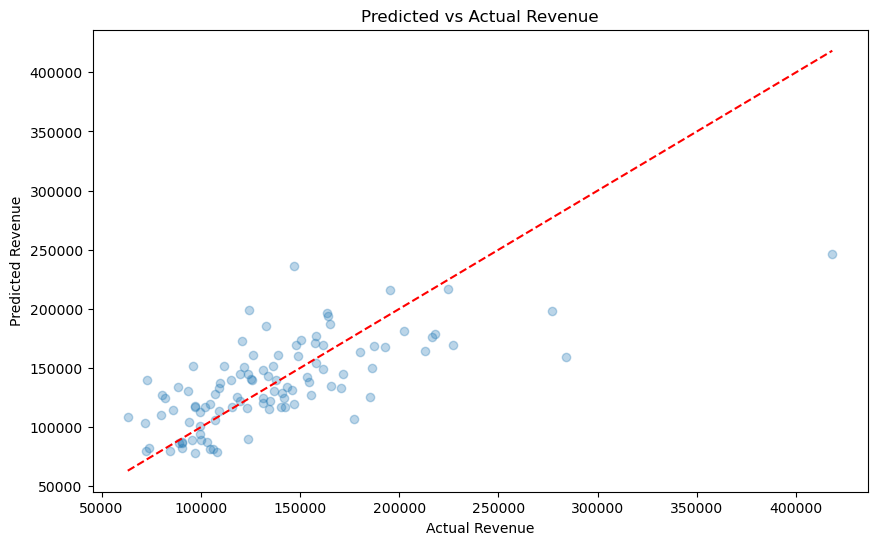

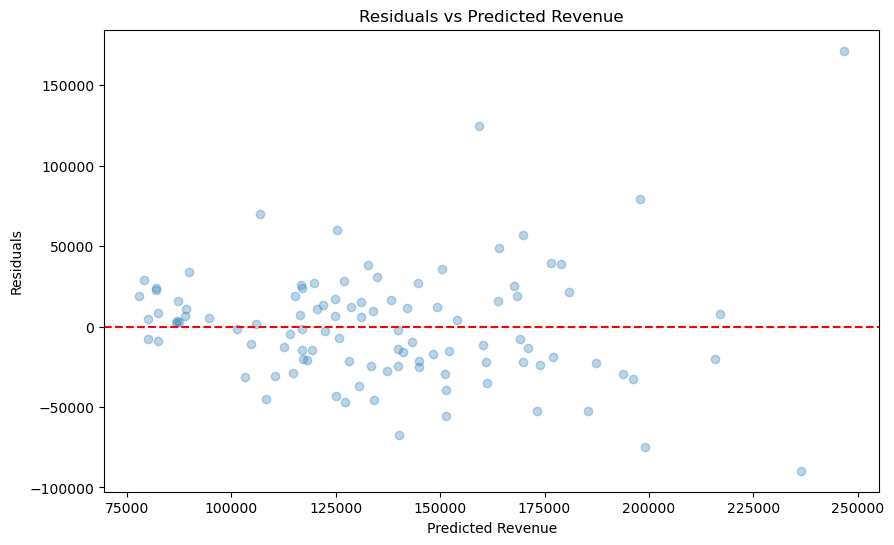

In [3022]:
import matplotlib.pyplot as plt

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Revenue')
plt.show()

# Residual plot
residuals = y - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Revenue')
plt.show()

In [3024]:
# Calculate residuals
residuals = y - predictions

# Analyze residuals
print(f'Mean of residuals: {np.mean(residuals)}')
print(f'Standard deviation of residuals: {np.std(residuals)}')

Mean of residuals: -44.840675562403845
Standard deviation of residuals: 36390.55659630863


# Return on investment ( ROI ) 

In [3051]:
total_revenue = y.sum()
total_revenue

14194979.830000002

In [3051]:
total_revenue = y.sum()
total_revenue

14194979.830000002

In [3060]:
# Example data
total_revenue = y.sum()  # Total revenue from your data
total_ad_cost = x[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                   'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                   'spend_channel_7']].sum().sum()  # Total advertising costs

# Assuming total non-ad costs are known (for example, $500,000)
total_non_ad_cost = 500000

# Net profit
net_profit = total_revenue - (total_ad_cost + total_non_ad_cost)

# ROI calculation
roi = (net_profit / (total_ad_cost + total_non_ad_cost)) * 100
print(f'Return on Investment (ROI): {roi:.2f}%')

Return on Investment (ROI): 84.05%


In [3053]:
total_spend_per_channel = x[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                             'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                             'spend_channel_7']].sum()
print("Total Spend Per Channel:")
print(total_spend_per_channel)

Total Spend Per Channel:
spend_channel_1     129542.90
spend_channel_2      35738.66
spend_channel_3    2028746.51
spend_channel_4     719174.22
spend_channel_5     891863.59
spend_channel_6     526624.70
spend_channel_7    2880942.21
dtype: float64


In [3055]:
roas_per_channel = total_revenue / total_spend_per_channel
print("ROAS Per Channel:")
print(roas_per_channel)

ROAS Per Channel:
spend_channel_1    109.577444
spend_channel_2    397.188362
spend_channel_3      6.996921
spend_channel_4     19.737887
spend_channel_5     15.916089
spend_channel_6     26.954641
spend_channel_7      4.927200
dtype: float64


In [3057]:
best_channel = roas_per_channel.idxmax()
print(f"The best channel in terms of ROAS is: {best_channel}")

The best channel in terms of ROAS is: spend_channel_2


In [3066]:
# Assuming revenue is proportionally attributed to channels based on their spend
revenue_per_channel = (total_spend_per_channel / total_spend_per_channel.sum()) * total_revenue
print("Revenue Per Channel:")
print(revenue_per_channel)

Revenue Per Channel:
spend_channel_1    2.549497e+05
spend_channel_2    7.033625e+04
spend_channel_3    3.992719e+06
spend_channel_4    1.415387e+06
spend_channel_5    1.755252e+06
spend_channel_6    1.036435e+06
spend_channel_7    5.669901e+06
dtype: float64


In [3068]:
net_profit_per_channel = revenue_per_channel - total_spend_per_channel
print("Net Profit Per Channel:")
print(net_profit_per_channel)

Net Profit Per Channel:
spend_channel_1    1.254068e+05
spend_channel_2    3.459759e+04
spend_channel_3    1.963972e+06
spend_channel_4    6.962123e+05
spend_channel_5    8.633881e+05
spend_channel_6    5.098106e+05
spend_channel_7    2.788959e+06
dtype: float64


In [3070]:
roi_per_channel = (net_profit_per_channel / total_spend_per_channel) * 100  # ROI in percentage
print("ROI Per Channel:")
print(roi_per_channel)

# Identify the Best Channel
best_channel = roi_per_channel.idxmax()
print(f"The best channel in terms of ROI is: {best_channel}")

ROI Per Channel:
spend_channel_1    96.807189
spend_channel_2    96.807189
spend_channel_3    96.807189
spend_channel_4    96.807189
spend_channel_5    96.807189
spend_channel_6    96.807189
spend_channel_7    96.807189
dtype: float64
The best channel in terms of ROI is: spend_channel_2


Refrencess :
- https://medium.com/@eddiezal/adstock-decay-secrets-master-your-marketing-analytics-game-6852c551b6fb

- https://keends.com/blog/the-benefits-of-bayesian-marketing-mix-modeling/#:~:text=Bayesian%20MMM%20is%20a%20flexible,market%20conditions%20and%20consumer%20behavior.

- https://github.com/leopoldavezac/BayesianMMM

- https://colab.research.google.com/github/arpitamangal/customer-segmentation/blob/main/CustomerLifetime%26SocialNetworkAnalysis.ipynb

- https://www.linkedin.com/pulse/spend-tracker-python-mehdi-mujtaba